# Reading data

In [71]:
import pandas as pd
import numpy as np

In [72]:
#data = pd.read_csv('articles_bbc_2018_01_30.csv')
data = pd.read_csv('emerce_articles_small.csv')
data.head(1)

,articles
0,[['De verwerker van online en mobiele betaling...


In [73]:
data = data.dropna().reset_index(drop=True)
data.articles = [w.replace('[[\'', '').replace('[\'', '').replace('\'],', '').replace('\']]','') for w in data.articles]
data.articles = data.articles.replace('', np.nan)
data = data.dropna().reset_index(drop=True)
data.count()

articles    794
dtype: int64

# Cleaning

#### Keeping Dutch articles

In [74]:
!pip install langdetect

You should consider upgrading via the 'pip install --upgrade pip' command.


In [75]:
from langdetect import detect
from tqdm.notebook import tqdm
tqdm().pandas()

In [76]:
data['lang'] = data.articles.progress_map(detect)

In [77]:
data.lang.value_counts()

nl    793
en      1
Name: lang, dtype: int64

In [78]:
data = data.loc[data.lang=='nl']

#### Tokenization

In [79]:
import nltk
nltk.do wnload('punkt')


[nltk_data] Downloading package punkt to /home/nbuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [80]:
from nltk.tokenize import sent_tokenize

In [81]:
data['sentences'] = data.articles.progress_map(sent_tokenize)
data['sentences'].head(1).tolist()[0][:3] # Print the first 3 sentences of the 1st article

['De verwerker van online en mobiele betalingen Multisafepay tekent een nieuw contract met zijn partner Paysquare.',
 'Na tien jaar samenwerking zien de partijen door de opkomst van meer en nieuwe kanalen de noodzaak om de werkrelatie aan te passen aan deze tijd en dat vast te leggen.',
 'Paysquare, onderdeel van Equens, zorgt ervoor dat bedrijven betalingen kunnen ontvangen met vrijwel alle merken betaalkaarten in Europa.']

In [82]:
from nltk.tokenize import word_tokenize

In [83]:
data['tokens_sentences'] = data['sentences'].progress_map(lambda sentences: [word_tokenize(sentence) for sentence in sentences])
print(data['tokens_sentences'].head(1).tolist()[0][:3])


[['De', 'verwerker', 'van', 'online', 'en', 'mobiele', 'betalingen', 'Multisafepay', 'tekent', 'een', 'nieuw', 'contract', 'met', 'zijn', 'partner', 'Paysquare', '.'], ['Na', 'tien', 'jaar', 'samenwerking', 'zien', 'de', 'partijen', 'door', 'de', 'opkomst', 'van', 'meer', 'en', 'nieuwe', 'kanalen', 'de', 'noodzaak', 'om', 'de', 'werkrelatie', 'aan', 'te', 'passen', 'aan', 'deze', 'tijd', 'en', 'dat', 'vast', 'te', 'leggen', '.'], ['Paysquare', ',', 'onderdeel', 'van', 'Equens', ',', 'zorgt', 'ervoor', 'dat', 'bedrijven', 'betalingen', 'kunnen', 'ontvangen', 'met', 'vrijwel', 'alle', 'merken', 'betaalkaarten', 'in', 'Europa', '.']]


#### Lemmatizing with POS tagging

In [84]:
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/nbuser/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/nbuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/nbuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [85]:
data['POS_tokens'] = data['tokens_sentences'].progress_map(lambda tokens_sentences: [pos_tag(tokens) for tokens in tokens_sentences])
print(data['POS_tokens'].head(1).tolist()[0][:3])


[[('De', 'NNP'), ('verwerker', 'NN'), ('van', 'NN'), ('online', 'NN'), ('en', 'IN'), ('mobiele', 'FW'), ('betalingen', 'NN'), ('Multisafepay', 'NNP'), ('tekent', 'NN'), ('een', 'NN'), ('nieuw', 'JJ'), ('contract', 'NN'), ('met', 'VBD'), ('zijn', 'NN'), ('partner', 'NN'), ('Paysquare', 'NNP'), ('.', '.')], [('Na', 'NNP'), ('tien', 'NN'), ('jaar', 'NN'), ('samenwerking', 'VBG'), ('zien', 'NN'), ('de', 'FW'), ('partijen', 'FW'), ('door', 'NN'), ('de', 'IN'), ('opkomst', 'FW'), ('van', 'FW'), ('meer', 'NN'), ('en', 'IN'), ('nieuwe', 'JJ'), ('kanalen', 'FW'), ('de', 'FW'), ('noodzaak', 'FW'), ('om', 'FW'), ('de', 'FW'), ('werkrelatie', 'FW'), ('aan', 'FW'), ('te', 'NN'), ('passen', 'NN'), ('aan', 'NN'), ('deze', 'NN'), ('tijd', 'NN'), ('en', 'IN'), ('dat', 'NN'), ('vast', 'JJ'), ('te', 'NN'), ('leggen', 'NN'), ('.', '.')], [('Paysquare', 'NNP'), (',', ','), ('onderdeel', 'NN'), ('van', 'NN'), ('Equens', 'NNP'), (',', ','), ('zorgt', 'NNP'), ('ervoor', 'VBZ'), ('dat', 'VB'), ('bedrijven', '

In [86]:
# Inspired from https://stackoverflow.com/a/15590384
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [87]:
# Lemmatizing each word with its POS tag, in each sentence
data['tokens_sentences_lemmatized'] = data['POS_tokens'].progress_map(
    lambda list_tokens_POS: [
        [
            lemmatizer.lemmatize(el[0], get_wordnet_pos(el[1])) 
            if get_wordnet_pos(el[1]) != '' else el[0] for el in tokens_POS
        ] 
        for tokens_POS in list_tokens_POS
    ]
)

In [88]:
data['tokens_sentences_lemmatized'].head(1).tolist()[0][:3]

[['De',
  'verwerker',
  'van',
  'online',
  'en',
  'mobiele',
  'betalingen',
  'Multisafepay',
  'tekent',
  'een',
  'nieuw',
  'contract',
  'meet',
  'zijn',
  'partner',
  'Paysquare',
  '.'],
 ['Na',
  'tien',
  'jaar',
  'samenwerking',
  'zien',
  'de',
  'partijen',
  'door',
  'de',
  'opkomst',
  'van',
  'meer',
  'en',
  'nieuwe',
  'kanalen',
  'de',
  'noodzaak',
  'om',
  'de',
  'werkrelatie',
  'aan',
  'te',
  'passen',
  'aan',
  'deze',
  'tijd',
  'en',
  'dat',
  'vast',
  'te',
  'leggen',
  '.'],
 ['Paysquare',
  ',',
  'onderdeel',
  'van',
  'Equens',
  ',',
  'zorgt',
  'ervoor',
  'dat',
  'bedrijven',
  'betalingen',
  'kunnen',
  'ontvangen',
  'meet',
  'vrijwel',
  'alle',
  'merken',
  'betaalkaarten',
  'in',
  'Europa',
  '.']]

#### Regrouping tokens and removing stop words

In [89]:
from nltk.corpus import stopwords
#stopwords_verbs = ['say', 'get', 'go', 'know', 'may', 'need', 'like', 'make', 'see', 'want', 'come', 'take', 'use', 'would', 'can']
#stopwords_other = ['one', 'mr', 'bbc', 'image', 'getty', 'de', 'en', 'caption', 'also', 'copyright', 'something']
#my_stopwords = stopwords.words('english') + stopwords_verbs + stopwords_other
stopwords_verbs = ['zegt']
stopwords_other = ['we', 'via']
my_stopwords = stopwords.words('dutch') + stopwords_verbs + stopwords_other

In [90]:
from itertools import chain # to flatten list of sentences of tokens into list of tokens

In [91]:
data['tokens'] = data['tokens_sentences_lemmatized'].map(lambda sentences: list(chain.from_iterable(sentences)))
data['tokens'] = data['tokens'].map(lambda tokens: [token.lower() for token in tokens if token.isalpha() 
                                                    and token.lower() not in my_stopwords and len(token)>1])

In [92]:
data['tokens'].head(1).tolist()[0][:30]

['verwerker',
 'online',
 'mobiele',
 'betalingen',
 'multisafepay',
 'tekent',
 'nieuw',
 'contract',
 'meet',
 'partner',
 'paysquare',
 'tien',
 'jaar',
 'samenwerking',
 'zien',
 'partijen',
 'opkomst',
 'nieuwe',
 'kanalen',
 'noodzaak',
 'werkrelatie',
 'passen',
 'tijd',
 'vast',
 'leggen',
 'paysquare',
 'onderdeel',
 'equens',
 'zorgt',
 'ervoor']

# LDA

## Data preparation

#### Prepare bi-grams and tri-grams

In [96]:
!pip install gensim
from gensim.models import Phrases

You should consider upgrading via the 'pip install --upgrade pip' command.


AttributeError: module 'smart_open' has no attribute 's3'

In [94]:
tokens = data['tokens'].tolist()
bigram_model = Phrases(tokens)
trigram_model = Phrases(bigram_model[tokens], min_count=1)
tokens = list(trigram_model[bigram_model[tokens]])

NameError: name 'Phrases' is not defined

#### Prepare objects for LDA gensim implementation

In [ ]:
from gensim import corpora

In [97]:
dictionary_LDA = corpora.Dictionary(tokens)
dictionary_LDA.filter_extremes(no_below=3)
corpus = [dictionary_LDA.doc2bow(tok) for tok in tokens]
dictionary_LDA

NameError: name 'corpora' is not defined

## Running LDA

In [ ]:
from gensim import models

In [ ]:
np.random.seed(123456)
num_topics = 20
%time lda_model = models.LdaModel(corpus, num_topics=num_topics, \
                                  id2word=dictionary_LDA, \
                                  passes=4, alpha=[0.01]*num_topics, \
                                  eta=[0.01]*len(dictionary_LDA.keys()))

## Quick exploration of LDA results

#### Looking at topics

In [ ]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20):
    print(str(i)+": "+ topic)
    print()

#### Allocating topics to documents

In [ ]:
print(data.articles.loc[0][:500])

In [ ]:
lda_model[corpus[0]]

#### Predicting topics on unseen documents

In [ ]:
document = '''De content clean-up: zeg meer met minder
Je herkent het vast wel. In de loop der jaren is je website steeds groter geworden. Je redactie heeft meer en meer pagina’s te beheren, en er komt dagelijks content bij. Hierdoor wordt het contentbeheer met de dag arbeidsintensiever. Redacteuren hebben minder tijd om de kwaliteit van alle content op peil te houden, waardoor je grip en overzicht kunt verliezen. De praktijk wijst uit dat er veel content is die niet meer actueel of relevant is.

Een opgeruimd huis geeft een opgeruimde geest. Je website zou eigenlijk ook jaarlijks een voorjaarsschoonmaak moeten krijgen. Met een content clean up verminder je de hoeveelheid content, wordt het contentbeheer voor je redactie minder arbeidsintensief, en kan de focus weer komen te liggen op kwaliteit en relevantie.
In vier stappen naar minder content
 
Lees ons uitgebreide artikel op Frankwatching (een van de best gelezen artikelen in de maand april).

Wat levert een content clean up op?
Het terugbrengen van je hoeveelheid content levert je veel voordelen op:

Betere beheersbaarheid
Het beheer van je content is na een content clean up minder arbeidsintensief, doordat je minder pagina’s te beheren hebt. Dit levert je financieel voordeel op.

Kwaliteitsverbetering
Doordat je minder content te beheren hebt, neemt de kwaliteit toe. Redacteuren hebben immers meer tijd per pagina. Na de content clean up heb je een helder overzicht van wat je online hebt staan en waarom. Dit heeft grip en overzicht. Hierdoor levert je content meer waarde op.

Hogere gebruiksvriendelijkheid
De gebruiksvriendelijkheid van je website zal toenemen. Je bezoekers vinden gerichter en sneller relevante en actuele content.

Betere vindbaarheid door relevantere content
In de content clean up beoordelen we alle content op relevantie. Door content te verwijderen die geen waarde meer biedt voor je organisatie en je doelgroep, zal de relevantie van je overgebleven content toenemen. Dit maakt je content beter vindbaar en zorgt ervoor dat je beter scoort in zoekmachines.'''
tokens = word_tokenize(document)
topics = lda_model.show_topics(formatted=True, num_topics=num_topics, num_words=20)
topics
#pd.DataFrame([(el[0], round(el[1],2), topics[el[0]][1]) for el in lda_model[dictionary_LDA.doc2bow(tokens)]], columns=['topic #', 'weight', 'words in topic'])

## Advanced exploration of LDA results

#### Allocation of topics in all documents

In [311]:
topics = [lda_model[corpus[i]] for i in range(len(data))]

In [312]:
def topics_document_to_dataframe(topics_document, num_topics):
    res = pd.DataFrame(columns=range(num_topics))
    for topic_weight in topics_document:
        res.loc[0, topic_weight[0]] = topic_weight[1]
    return res

topics_document_to_dataframe([(9, 0.03853655432967504), (15, 0.09130117862212643), (18, 0.8692868808484044)], 20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0385366,NaN,NaN,NaN,NaN,NaN,0.0913012,NaN,NaN,0.869287,NaN


In [313]:
# Like TF-IDF, create a matrix of topic weighting, with documents as rows and topics as columns
document_topic = \
pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in topics]) \
  .reset_index(drop=True).fillna(0)

In [314]:
document_topic.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.0,0.000000,0.211634,0.00000,0.0,0.150421,0.0,0.557608,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.076791,0.0
1,0.0,0.000000,0.000000,0.05916,0.0,0.111922,0.0,0.611373,0.0,0.0,0.212235,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0
2,0.0,0.098827,0.000000,0.00000,0.0,0.631776,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.207601,0.0,0.000000,0.057992,0.0,0.000000,0.0
3,0.0,0.158495,0.026630,0.00000,0.0,0.000000,0.0,0.042379,0.0,0.0,0.000000,0.424339,0.081586,0.000000,0.0,0.000000,0.000000,0.0,0.264239,0.0
4,0.0,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.177564,0.164817,0.000000,0.087561,0.0,0.567396,0.000000,0.0,0.000000,0.0


In [315]:
# Which document are about topic 14
document_topic.sort_values(14, ascending=False)[14].head(20)

1853    0.995384
487     0.943671
1258    0.927258
1475    0.920958
1075    0.866875
178     0.845005
641     0.844715
1519    0.812754
976     0.811372
5086    0.811320
1291    0.793144
1933    0.790626
722     0.790591
335     0.776081
608     0.770491
476     0.767624
6929    0.766648
167     0.759262
768     0.755315
1084    0.753507
Name: 14, dtype: float64

In [316]:
print(data.articles.loc[91][:1000])

IBM heeft dinsdag een ontwikkellab geopend in Groningen om Nederlandse bedrijven bij te staan met technische datagedreven ontwikkelingen. Uiteindelijk moeten er zo’n vierhonderd medewerkers komen. Het nieuwe centrum is gevestigd in het IBM Services Center aan het Zuiderdiep en biedt onderdak aan teams van de IBM Interactive Experience, ‘het grootste digitale agentschap in de wereld’. De nadruk ligt op gebruikerservaring. In totaal heeft IBM 25 van dergelijke studio’s in onder meer Atlanta, Austin, Bangalore, Beijing, Boston, Chicago, Dallas, Ehningen, Hursley, Madrid, Melbourne en Toronto. Dit jaar komen er nog eens enkele centra bij. Op dit moment zijn er zo’n honderd mensen werkzaam. Een van de klanten is supermarkt Jumbo.


#### Looking at the distribution of topics in all documents

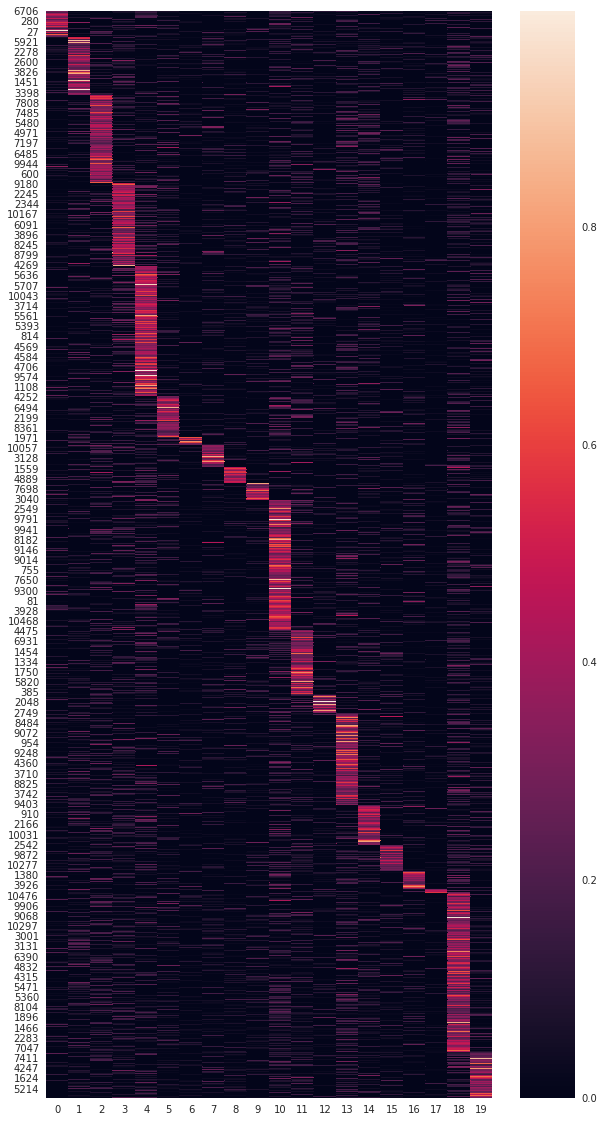

In [317]:
%matplotlib inline
import seaborn as sns; sns.set(rc={'figure.figsize':(10,20)})
sns.heatmap(document_topic.loc[document_topic.idxmax(axis=1).sort_values().index])

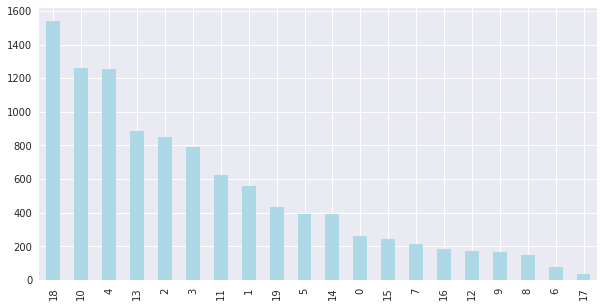

In [ ]:
sns.set(rc={'figure.figsize':(10,5)})
document_topic.idxmax(axis=1).value_counts().plot.bar(color='lightblue')

#### Visualizing topics

In [ ]:
# https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf
# Here a short legend to explain the vis:
# size of bubble: proportional to the proportions of the topics across the N total tokens in the corpus
# red bars: estimated number of times a given term was generated by a given topic
# blue bars: overall frequency of each term in the corpus
# -- Relevance of words is computed with a parameter lambda
# -- Lambda optimal value ~0.6 (https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf)
%matplotlib inline
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim
vis = pyLDAvis.gensim.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary_LDA)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)